In [36]:
import pandas as pd
import glob
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

# 1. Data 

## I did not include the script for importing data from excel files. All data are organized into dataframe

In [3]:
df.shape

(9873, 34)

In [4]:
df.head()

,id,vv_lh_x,vv_lh_y,vv_lh_z,vv_rh_x,vv_rh_y,vv_rh_z,vv_lw_x,vv_lw_y,vv_lw_z,...,va_rw_z,sv_lh,sv_rh,sv_lw,sv_rw,sa_lh,sa_rh,sa_lw,sa_rw,phase
0,0,-0.000332,0.000262,0.000866,-0.000231,-0.000124,-0.000551,-0.000320,0.000854,0.001547,...,0.000026,0.000964,0.000611,0.001795,0.000203,0.000238,0.000147,0.000061,0.000026,0.0
1,1,0.000551,-0.000415,-0.002184,-0.000137,-0.000143,-0.000280,-0.000581,0.000632,0.003374,...,0.000014,0.002290,0.000343,0.003481,0.000158,0.000984,0.000087,0.000563,0.000035,0.0
2,2,0.000069,-0.000327,-0.001134,0.000018,-0.000083,0.000055,-0.000579,0.000430,0.003996,...,0.000025,0.001182,0.000101,0.004061,0.000267,0.000322,0.000104,0.000182,0.000063,0.0
3,3,-0.000092,-0.000294,-0.000287,0.000121,-0.000050,0.000195,-0.000507,0.000128,0.003216,...,0.000004,0.000421,0.000234,0.003258,0.000320,0.000269,0.000055,0.000262,0.000023,0.0
4,4,-0.000780,0.000197,0.002274,0.000165,0.000032,0.000341,0.001153,-0.000440,-0.006310,...,0.000017,0.002412,0.000380,0.006429,0.000304,0.000843,0.000054,0.003027,0.000044,0.0


In [23]:
y=df.phase.tolist()
X=df.drop(['id','phase'], axis=1)

In [24]:
X.head()

,vv_lh_x,vv_lh_y,vv_lh_z,vv_rh_x,vv_rh_y,vv_rh_z,vv_lw_x,vv_lw_y,vv_lw_z,vv_rw_x,...,va_rw_y,va_rw_z,sv_lh,sv_rh,sv_lw,sv_rw,sa_lh,sa_rh,sa_lw,sa_rw
0,-0.000332,0.000262,0.000866,-0.000231,-0.000124,-0.000551,-0.000320,0.000854,0.001547,-0.000075,...,-0.000001,0.000026,0.000964,0.000611,0.001795,0.000203,0.000238,0.000147,0.000061,0.000026
1,0.000551,-0.000415,-0.002184,-0.000137,-0.000143,-0.000280,-0.000581,0.000632,0.003374,-0.000063,...,-0.000032,0.000014,0.002290,0.000343,0.003481,0.000158,0.000984,0.000087,0.000563,0.000035
2,0.000069,-0.000327,-0.001134,0.000018,-0.000083,0.000055,-0.000579,0.000430,0.003996,-0.000040,...,-0.000058,0.000025,0.001182,0.000101,0.004061,0.000267,0.000322,0.000104,0.000182,0.000063
3,-0.000092,-0.000294,-0.000287,0.000121,-0.000050,0.000195,-0.000507,0.000128,0.003216,-0.000030,...,-0.000023,0.000004,0.000421,0.000234,0.003258,0.000320,0.000269,0.000055,0.000262,0.000023
4,-0.000780,0.000197,0.002274,0.000165,0.000032,0.000341,0.001153,-0.000440,-0.006310,0.000015,...,0.000038,0.000017,0.002412,0.000380,0.006429,0.000304,0.000843,0.000054,0.003027,0.000044


# 2. Classification modeling

In [73]:
def evaluate_model(model, X, y, param_grid={}):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    
    # Normalization
    s = StandardScaler()
    xtrain = s.fit_transform(xtrain)
    xtest = s.transform(xtest)
    
    clf = GridSearchCV(model, param_grid, cv=5)#, scoring='roc_auc')
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    try:
        yproba = clf.decision_function(xtest)
    except AttributeError:
        yproba = clf.predict_proba(xtest)[:, 1]
    cnf = confusion_matrix(ytest, ypred)
    return clf, cnf

In [38]:
models = {'gbt': OneVsRestClassifier(GradientBoostingClassifier()),
          'knn': KNeighborsClassifier(),
          'xgbt': OneVsRestClassifier(XGBClassifier()),
          'ada': OneVsRestClassifier(AdaBoostClassifier()),
          'dt': OneVsRestClassifier(DecisionTreeClassifier()),
          'edt': OneVsRestClassifier(ExtraTreesClassifier()),
          'rf': OneVsRestClassifier(RandomForestClassifier()),
          'lr': OneVsRestClassifier(LogisticRegression()),
          'svc': OneVsRestClassifier(SVC(kernel='rbf')),
          'nb':GaussianNB()}
grids = {}
keys = list(models.keys())
confusion_matrices = {}

for key in keys:
    model = models[key]
    model, conf_mat = evaluate_model(model, X,y, param_grid=grids.get(key, {}))
    models[key] = model
    confusion_matrices[key] = conf_mat

/Users/jaykim/anaconda/lib/python3.6/site-packages/sklearn/multiclass.py:352: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


# 3. Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, ax, title, normalize=False, cmap=plt.cm.Blues):
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                horizontalalignment="center", size=20,
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

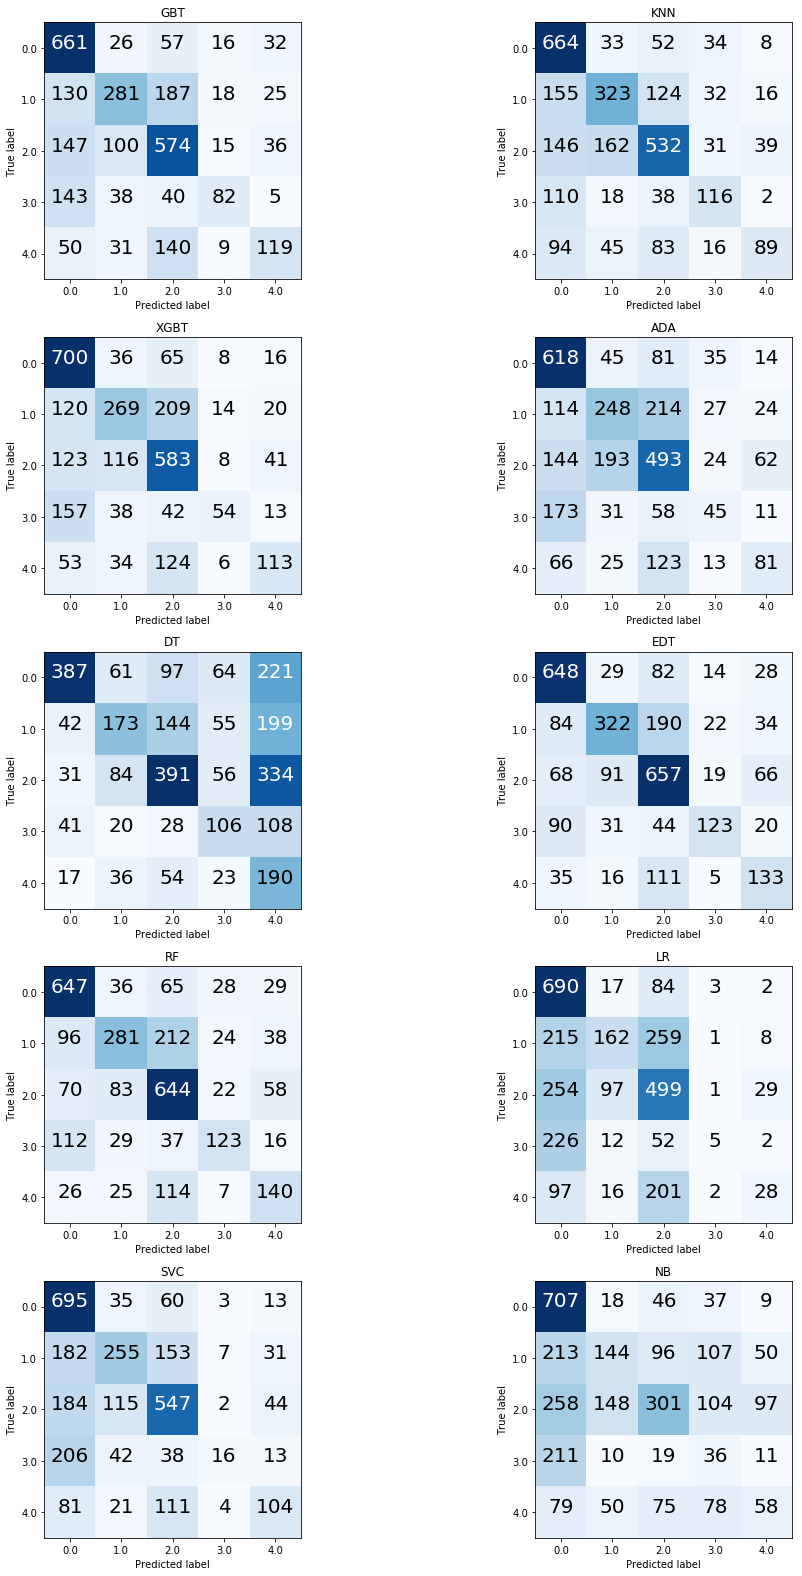

In [181]:
fig, axes = plt.subplots(nrows=len(models)//2, ncols=2, figsize=(16, 22))
axes = axes.reshape(-1)
for ax, (key, conf_mat) in zip(axes, confusion_matrices.items()):
    classes = models[key].best_estimator_.classes_
    plot_confusion_matrix(conf_mat, classes, ax, key.upper())
fig.tight_layout()

# 4. F1 score calculation

In [156]:
def f1_cal(conf_mat, model):
    pr=[(conf_mat[model][i][i]/conf_mat[model][i].sum()) for i in range(5)]
    re=[(conf_mat[model][i][i]/(sum(row[i] for row in conf_mat[model]))) for i in range(5)]
    f1= [2*pr[i]*re[i]/(pr[i]+re[i]) for i in range(5)]
    return f1

In [157]:
# For EDT model
f1_cal(confusion_matrices,'edt')

[0.75086906141367316,
 0.56441717791411039,
 0.66196473551637269,
 0.50101832993890016,
 0.45783132530120485]

In [147]:
# For RF model
f1_cal(confusion_matrices,'rf')

[0.7369020501138952,
 0.50859728506787327,
 0.66085171883016935,
 0.47216890595009597,
 0.47217537942664423]

# 5. Parameter Tuining

In [28]:
from sklearn.metrics import accuracy_score

def param_opti(model, parameter, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    clf = GridSearchCV(model, parameter, cv=5)#, scoring='roc_auc')
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    try:
        yproba = clf.decision_function(xtest)
    except AttributeError:
        yproba = clf.predict_proba(xtest)[:, 1]
    cnf = confusion_matrix(ytest, ypred)
    accuracy = accuracy_score(ytest, ypred)
    return clf, cnf,  accuracy

## 5.1 RF parameter tuning

In [58]:
rf = RandomForestClassifier()
param = [{'n_estimators': [10,100,1000], 'max_features': ['auto','sqrt','log2']}]
clf_svc, cnf_svc, accuracy_svc = param_opti(rf,param, X, y)

In [60]:
def plot_confusion_matrix2(cm, normalize=False, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center", size=20,
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

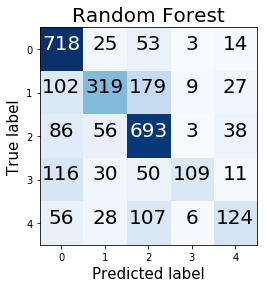

In [102]:
plot_confusion_matrix2(cnf_svc)
fig.tight_layout()
plt.title('Random Forest',fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.savefig('rf_multi.png', bbox_inches='tight')

In [149]:
def f1_cal_2(conf_mat):
    pr=[(conf_mat[i][i]/conf_mat[i].sum()) for i in range(5)]
    re=[(conf_mat[i][i]/(sum(row[i] for row in conf_mat))) for i in range(5)]
    f1= [2*pr[i]*re[i]/(pr[i]+re[i]) for i in range(5)]
    return f1

In [150]:
f1_cal_2(cnf_svc)

[0.75938656795346382,
 0.58318098720292511,
 0.7078651685393258,
 0.48878923766816146,
 0.46355140186915889]

In [62]:
clf_svc.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [68]:
rf = RandomForestClassifier(max_features= 'sqrt', n_estimators= 1000)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

## 5.2 EDT parameter tuning

In [63]:
edt = ExtraTreesClassifier()
param = [{'n_estimators': [10,100,1000], 'max_features': ['auto','sqrt','log2']}]
clf, cnf, accuracy = param_opti(edt,param, X, y)

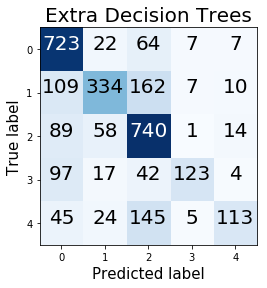

In [104]:
plot_confusion_matrix2(cnf)
fig.tight_layout()
plt.title('Extra Decision Trees', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.savefig('edt_multi.png', bbox_inches='tight')

In [158]:
f1_cal_2(cnf)

[0.76670201484623535,
 0.62024141132776234,
 0.72019464720194637,
 0.57746478873239437,
 0.47083333333333344]

In [66]:
clf.best_params_

{'max_features': 'auto', 'n_estimators': 1000}

In [70]:
edt = ExtraTreesClassifier(max_features= 'auto', n_estimators= 1000)
edt.fit(X,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

# 6. Feature importance

In [69]:
rf.feature_importances_

array([ 0.02759489,  0.03978262,  0.03458497,  0.02821536,  0.04772732,
        0.03405927,  0.02723215,  0.03891709,  0.03305551,  0.02828616,
        0.05449442,  0.03261742,  0.02167691,  0.02320667,  0.02291351,
        0.02279029,  0.02486832,  0.02340243,  0.0210127 ,  0.02286586,
        0.0223411 ,  0.02175656,  0.02546826,  0.02327945,  0.03766586,
        0.05086863,  0.03429923,  0.05318482,  0.02755808,  0.03658817,
        0.02628714,  0.03139882])

In [71]:
edt.feature_importances_

array([ 0.03069488,  0.04127356,  0.03330487,  0.03194971,  0.04939073,
        0.03282266,  0.02988245,  0.0398543 ,  0.03247981,  0.0323935 ,
        0.05048505,  0.03275264,  0.02258938,  0.02427835,  0.02329101,
        0.02317263,  0.02549582,  0.0238452 ,  0.02187181,  0.02376998,
        0.02248912,  0.02297566,  0.02614283,  0.02359749,  0.03904271,
        0.04881081,  0.0369449 ,  0.0493131 ,  0.02564656,  0.02739235,
        0.02528148,  0.02676467])

### Check my blog to see what features are acutally important to predict the motions